## Starter code

**Initialization issues to be aware of:**

**1. softmax confidently wrong:** a proper initialization of parameters should yield an initial `uniform distribution loss`. In the case in hand, representing an equal probability of any random character following a given input, since we do not have any reason to believe that any character is more likely than any other at initialization (approximately $3.3$ in this case, given by the negative log of $\frac{1}{27}$). Also, note that the weights should be initialized with very small random numbers, but not zeroes, since that could lead to unusual outcomes when multiplied by the inputs; the biases may be initialized as zeroes, since they are simply added.

**2. activation layer too saturated:** when using activation functions such as tanh, sigmoid, relu, among others, in the hidden states, the more extreme the values are (eg. $-1$ and $1$ for tanh), the more active the squashing is, which may result in halting the backpropagation through the neuron. During backprop, the derivative of the activation function is calculated using the chain rule, with the local gradient taking the form of $1 - t^{2}$ for tanh, meaning that if $t=1$ or $t=-1$ the derivative will be $0$, effectively stopping backpropagation through this unit. If this happens at initialization, the neuron will be forever dead. On the other hand, when $t=0$, the derivative is $1$ and the gradient is passed through. This will apply to any activation function that has a flat region in its shape.

<figure><img src="../assets/activation-functions.png" width=500></figure>

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import json

names = json.loads(open("../data/names.txt", "r").read())
names = names["payload"]["blob"]["rawLines"]
names[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
print("Length of dataset: ", len(names))

Length of dataset:  32033


In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set("".join(names))))
chtoi = {ch:i+1 for i, ch in enumerate(chars)}
chtoi["."] = 0
itoch = {i:ch for ch, i in chtoi.items()}
vocab_size = len(chtoi)
print("chtoi: ", chtoi)
print("itoch: ", itoch)
print("vocab_size: ", vocab_size)

chtoi:  {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
itoch:  {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
vocab_size:  27


In [5]:
import random

def build_dataset(data, mode="tr", context_len=3):
    """
    Builds the dataset from the given list of words.

    Args:
        data (list): list of words to use
        mode (str): mode of the dataset (default: "tr" for training)
        context_len (int): length of the context window (default: 3)
    """

    X, y = [], []

    for word in data:
        context = [0] * context_len
        for ch in word + ".":
            ix = chtoi[ch]
            X.append(context)
            y.append(ix)
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    y = torch.tensor(y)

    print(f"X{mode}.shape: {X.shape}, y{mode}.shape: {y.shape}")
    return X, y


random.shuffle(names)
n1 = int(0.8 * len(names))
n2 = int(0.9 * len(names))

Xtr, ytr = build_dataset(names[:n1])
Xval, yval = build_dataset(names[n1:n2], mode="val")
Xte, yte = build_dataset(names[n2:], mode="te")

Xtr.shape: torch.Size([182659, 3]), ytr.shape: torch.Size([182659])
Xval.shape: torch.Size([22661, 3]), yval.shape: torch.Size([22661])
Xte.shape: torch.Size([22826, 3]), yte.shape: torch.Size([22826])


In [6]:
# MLP revisited
n_embd = 10     # the dimensionality of the character embeddings vector
n_hidden = 200  # the number of neurons in the hidden layer
context_len = 3 # the length of the context window

C = torch.randn(vocab_size, n_embd)
W1 = torch.randn(n_embd * context_len, n_hidden) * 0.1
b1 = torch.randn(n_hidden)                       * 0.0
W2 = torch.randn(n_hidden, vocab_size)           * 0.1
b2 = torch.randn(vocab_size)                     * 0.0

params = [C, W1, b1, W2, b2]
print("Number of parameters: ", sum([p.nelement() for p in params]))

for p in params:
    p.requires_grad = True

Number of parameters:  11897


In [7]:
# same optimization as last time
steps = 200_000
batch_size = 32
lossi = []

exp_loss = -torch.tensor(1.0 / vocab_size).log()
print(f"Expected initial loss: {exp_loss}")

for step in range(steps):
  # minibatch construction
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, yb = Xtr[ix], ytr[ix]            # batch X, y

  # forward pass
  emb = C[Xb]                          # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1)  # concatenate the vectors
  hpreact = embcat @ W1 + b1           # hidden layer pre-activation
  h = torch.tanh(hpreact)              # hidden layer
  logits = h @ W2 + b2                 # output layer
  loss = F.cross_entropy(logits, yb)   # loss function
  lossi.append(loss.log10().item())

  # backward pass
  for p in params:
      p.grad = None
  loss.backward()

  # update
  lr = 0.1 if step < 100_000 else 0.01 # step learning rate decay
  for p in params:
      p.data -= lr * p.grad

  # track stats
  if step == 0:
    print(f"Loss at {step:7d}/{steps:7d}: {loss.item():.4f}")
    hpreacti, hi = hpreact, h

  if (step+1) % 20_000 == 0:
      print(f"Loss at {(step+1):7d}/{steps:7d}: {loss.item():.4f}")

Expected initial loss: 3.295836925506592
Loss at       0/ 200000: 3.4064
Loss at   20000/ 200000: 1.9572
Loss at   40000/ 200000: 2.0308
Loss at   60000/ 200000: 2.0041
Loss at   80000/ 200000: 2.0920
Loss at  100000/ 200000: 2.3054
Loss at  120000/ 200000: 2.1404
Loss at  140000/ 200000: 1.9846
Loss at  160000/ 200000: 2.1605
Loss at  180000/ 200000: 2.2487
Loss at  200000/ 200000: 2.0461


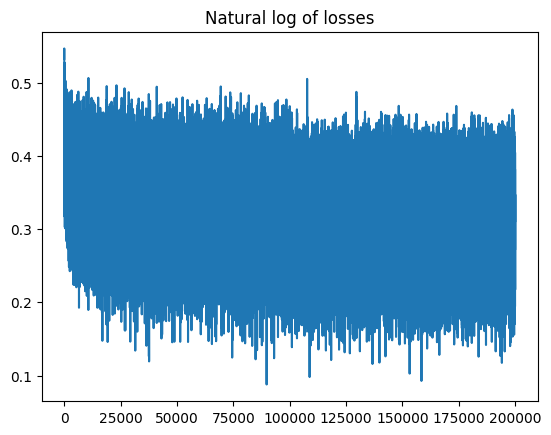

In [8]:
plt.plot(lossi)
plt.title("Natural log of losses");

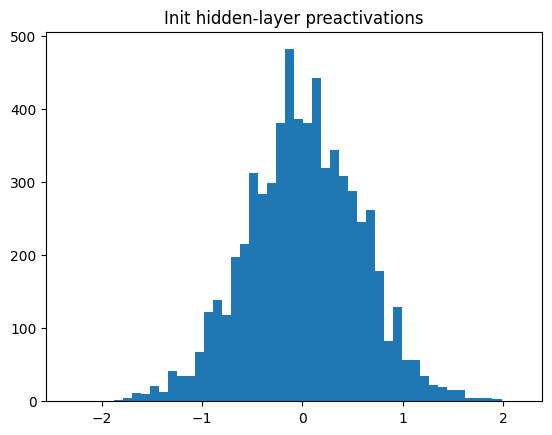

In [9]:
plt.hist(hpreacti.view(-1).tolist(), 50)
plt.title("Init hidden-layer preactivations");

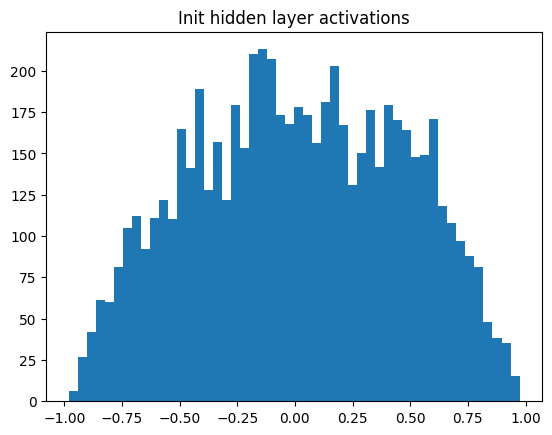

In [10]:
plt.hist(hi.view(-1).tolist(), 50)
plt.title("Init hidden layer activations");

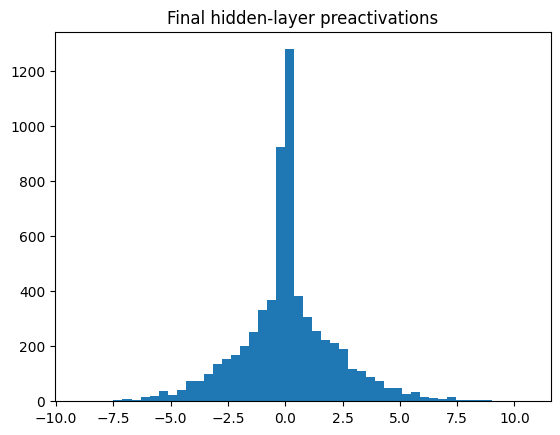

In [11]:
plt.hist(hpreact.view(-1).tolist(), 50)
plt.title("Final hidden-layer preactivations");

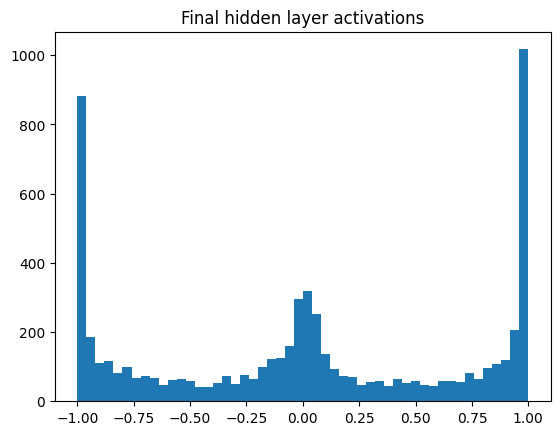

In [12]:
plt.hist(h.view(-1).tolist(), 50)
plt.title("Final hidden layer activations");

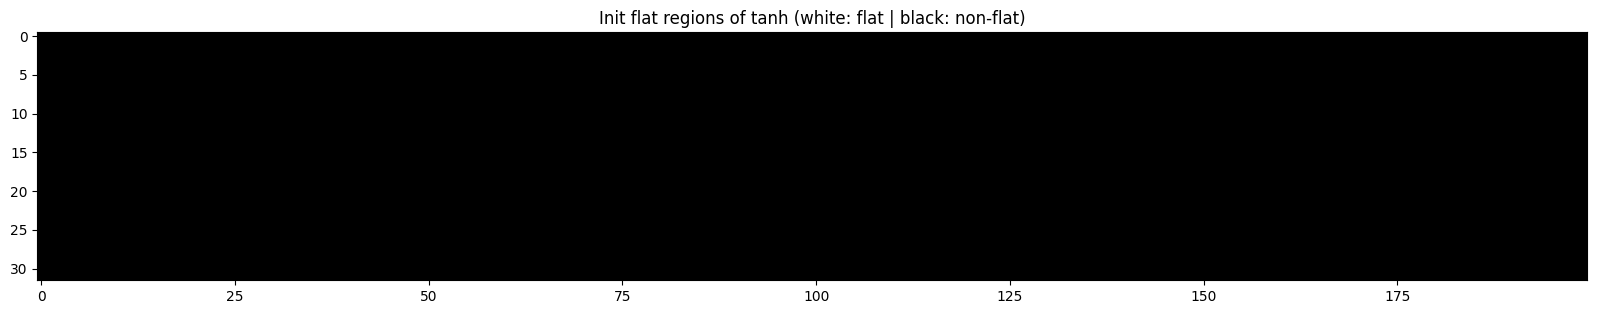

In [13]:
plt.figure(figsize=(20, 10))
plt.imshow(hi.abs() > 0.99, cmap="gray", interpolation="nearest")
plt.title("Init flat regions of tanh (white: flat | black: non-flat)");

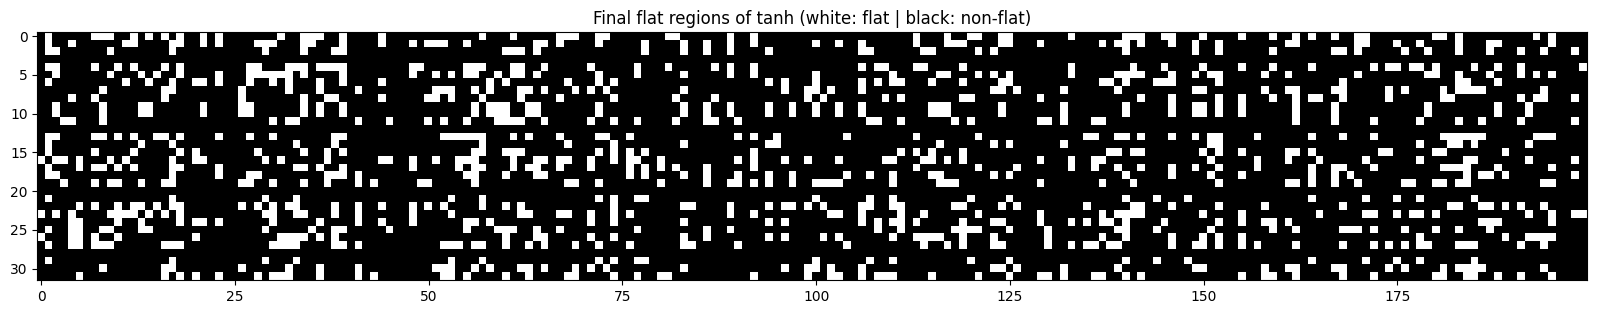

In [14]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap="gray", interpolation="nearest")
plt.title("Final flat regions of tanh (white: flat | black: non-flat)");

In [15]:
@torch.no_grad()                      # disable autograd (could be context manager torch.no_grad)
def split_loss(split):
  X, y = {"train": (Xtr, ytr), "val": (Xval, yval), "test": (Xte, yte)}[split]

  emb = C[X]                          # (N, context_len, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, context_len * n_embd)
  h = torch.tanh(embcat @ W1 + b1)    # (N, n_hidden)
  logits = h @ W2 + b2                # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(f"Split: {split} | loss: {loss.item():.4f}")

split_loss("train")
split_loss("val")

Split: train | loss: 2.0482
Split: val | loss: 2.1247


In [16]:
# sampling from the model
for _ in range(20):
    out = []
    context = [0] * context_len

    while True:
        emb = C[torch.tensor(context)]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print("".join([itoch[i] for i in out]))

midah.
leigh.
sardi.
washa.
shie.
mary.
lockee.
rydani.
junia.
ali.
carlinah.
willab.
hazlayiaminathory.
henley.
pailey.
kayah.
galishlyn.
ny.
dylah.
ivy.


## Kaiming initialization

As seen below, matrix multiplication will change the standard deviation of Gaussian distributions, specifically expanding or compressing the standard deviation. This situation is not ideal in the context of neural networks, because it will result in different activation thresholds across the model.

In order to scale the weights to preserve an uniform distribution at initialization, the weights matrices should be initialized by dividing the random values by the square root of the number of inputs ($\frac{{\text{{random values}}}}{{\sqrt{\text{{number of inputs}}}}}$). This is known as `Xavier initialization`.

`Kaiming initialization` is a variation of this method that proposes a different scaling factor that compensates for the squashing effect of the activation function, leading to an initialization such as the weights are scaled by $\frac{{\text{{random values}}}}{{\text{{gain}} \times \sqrt{\text{{number of inputs}}}}}$. Kaiming initialization is implemented in PyTorch with a standard gain of $\frac{5}{3}$ for tanh.

If the weights are properly initialized, not only the forward pass will be more stable, but also backpropagation will be more likely to flow through the network, due to the fact that the gradients will be more likely to be in the range of the activation function's linear region. A few other modern innovations have been proposed to improve the initialization of neural networks, such as `residual connections`, `normalization layers` (eg. batch normalization, layer normalization, group normalization, etc) and better `optimizers` (eg. Adam, RMSProp, etc).

In [17]:
n_inputs = 10
in_features = 1_000
out_features = 200

X:: mean: -0.01 | standard deviation: 1.00
y:: mean: 0.00 | standard deviation: 3.15


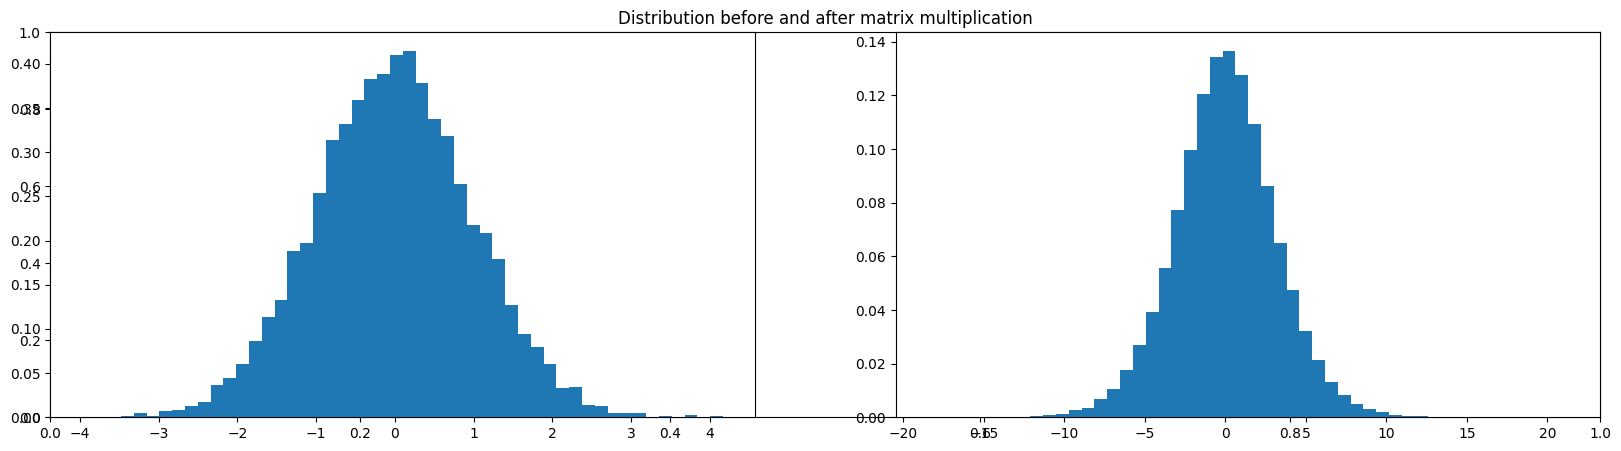

In [18]:
# standard matrix multiplication
X = torch.randn(in_features, n_inputs)
w = torch.randn(n_inputs, out_features)
y = X @ w
print(f"X:: mean: {X.mean():.2f} | standard deviation: {X.std():.2f}")
print(f"y:: mean: {y.mean():.2f} | standard deviation: {y.std():.2f}")

plt.figure(figsize=(20,5))
plt.title("Distribution before and after matrix multiplication")
plt.subplot(121)
plt.hist(X.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

X:: mean: 0.00 | standard deviation: 1.00
y:: mean: 0.00 | standard deviation: 1.00


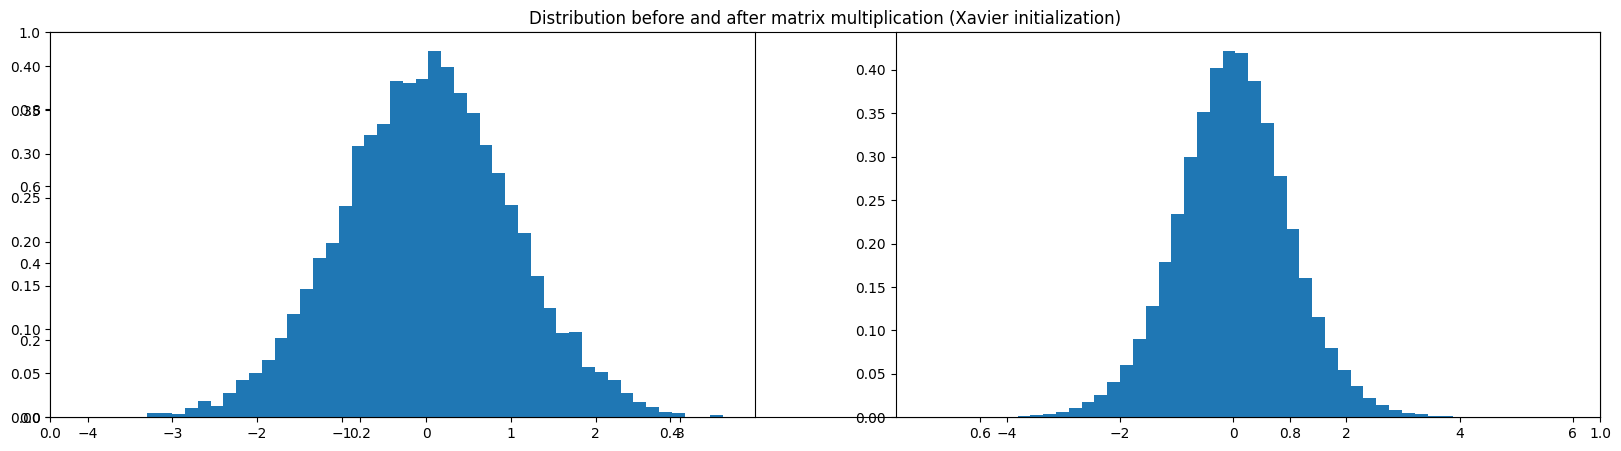

In [21]:
import math

# Xavier initialization
X = torch.randn(in_features, n_inputs)
w = torch.randn(n_inputs, out_features) / math.sqrt(n_inputs)
y = X @ w
print(f"X:: mean: {X.mean():.2f} | standard deviation: {X.std():.2f}")
print(f"y:: mean: {y.mean():.2f} | standard deviation: {y.std():.2f}")

plt.figure(figsize=(20,5))
plt.title("Distribution before and after matrix multiplication (Xavier initialization)")
plt.subplot(121)
plt.hist(X.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

X:: mean: 0.01 | standard deviation: 1.00
y:: mean: -0.00 | standard deviation: 0.59


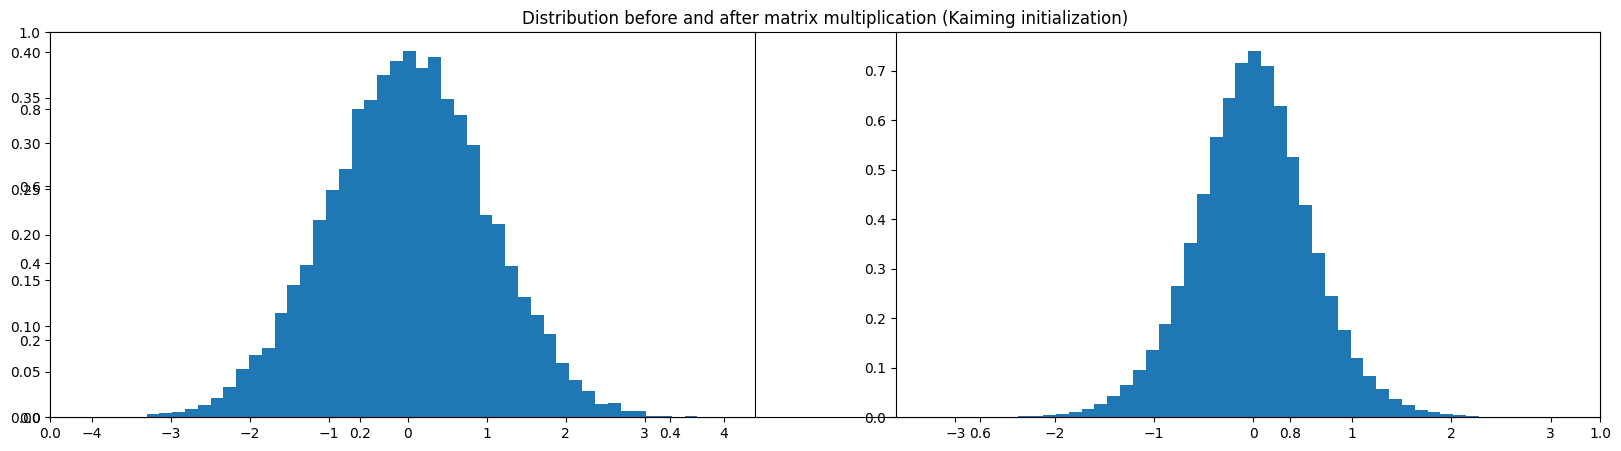

In [23]:
# Kaiming initialization
gain = 5.0 / 3.0
X = torch.randn(in_features, n_inputs)
w = torch.randn(n_inputs, out_features) / (gain * math.sqrt(n_inputs))
y = X @ w
print(f"X:: mean: {X.mean():.2f} | standard deviation: {X.std():.2f}")
print(f"y:: mean: {y.mean():.2f} | standard deviation: {y.std():.2f}")

plt.figure(figsize=(20,5))
plt.title("Distribution before and after matrix multiplication (Kaiming initialization)")
plt.subplot(121)
plt.hist(X.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

In [24]:
# MLP revisited (Kaiming initialization)
C = torch.randn(vocab_size, n_embd)
W1 = torch.randn(n_embd * context_len, n_hidden) / (gain * math.sqrt(n_embd * context_len))
b1 = torch.zeros(n_hidden)
W2 = torch.randn(n_hidden, vocab_size) / (gain * math.sqrt(n_hidden))
b2 = torch.zeros(vocab_size)

params = [C, W1, b1, W2, b2]
print("Number of parameters: ", sum([p.nelement() for p in params]))

for p in params:
    p.requires_grad = True

Number of parameters:  11897


In [25]:
for step in range(steps):
  # minibatch construction
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, yb = Xtr[ix], ytr[ix]            # batch X, y

  # forward pass
  emb = C[Xb]                          # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1)  # concatenate the vectors
  hpreact = embcat @ W1 + b1           # hidden layer pre-activation
  h = torch.tanh(hpreact)              # hidden layer
  logits = h @ W2 + b2                 # output layer
  loss = F.cross_entropy(logits, yb)   # loss function

  # backward pass
  for p in params:
      p.grad = None
  loss.backward()

  # update
  lr = 0.1 if step < 100_000 else 0.01 # step learning rate decay
  for p in params:
      p.data -= lr * p.grad

  # track stats
  if step == 0:
    print(f"Loss at {step:7d}/{steps:7d}: {loss.item():.4f}")

  if (step+1) % 20_000 == 0:
      print(f"Loss at {(step+1):7d}/{steps:7d}: {loss.item():.4f}")

Expected initial loss: 3.295836925506592
Loss at       0/ 200000: 3.3467
Loss at   20000/ 200000: 2.5866
Loss at   40000/ 200000: 1.9515
Loss at   60000/ 200000: 2.0169
Loss at   80000/ 200000: 2.1437
Loss at  100000/ 200000: 2.1823
Loss at  120000/ 200000: 1.8326
Loss at  140000/ 200000: 1.7660
Loss at  160000/ 200000: 1.9987
Loss at  180000/ 200000: 1.6957
Loss at  200000/ 200000: 2.1981


## Batch Normalization

Batch normalization is used to control the statistics of the activations in the network at initialization, by normalizing the inputs to the activation function. This is done by subtracting the mean and dividing by the standard deviation of the batch, and then scaling and offsetting (ie. calibrating) the result by learnable parameters. This process is done for each feature independently, and the learnable parameters are $\gamma$ and $\beta$, which are learned during training. It also has two non-learnable buffers to store the running mean and standard deviation, which are used during inference.

It is common to sprinkle batch normalization layers across the neural network to improve the training process and usually they will be placed after layers that have multiplications, such as fully connected layers and convolutional layers.

<img src="../assets/batch-norm-algo.jpg" width="400"/>

### Explicit calibration implementation

In [26]:
C = torch.randn(vocab_size, n_embd)
W1 = torch.randn(n_embd * context_len, n_hidden) / (gain * math.sqrt(n_embd * context_len))
W2 = torch.randn(n_hidden, vocab_size) / (gain * math.sqrt(n_hidden))
b2 = torch.zeros(vocab_size)
gamma = torch.ones((1, n_hidden))
beta = torch.zeros((1, n_hidden))

params = [C, W1, W2, b2, gamma, beta]

for p in params:
    p.requires_grad = True

In [27]:
for step in range(steps):
  # minibatch construction
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, yb = Xtr[ix], ytr[ix]            # batch X, y

  # forward pass
  emb = C[Xb]                          # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1)  # concatenate the vectors

  # linear layer
  hpreact = embcat @ W1                # hidden layer pre-activation (no bias when using batch norm)

  # batch norm layer
  mean = hpreact.mean(0, keepdim=True)
  std = hpreact.std(0, keepdim=True)
  epsilon = 1e-5
  hpreact = gamma * (hpreact - mean) / (std + epsilon) + beta

  # non-linearity (activation)
  h = torch.tanh(hpreact)              # hidden layer
  logits = h @ W2 + b2                 # output layer
  loss = F.cross_entropy(logits, yb)   # loss function

  # backward pass
  for p in params:
      p.grad = None
  loss.backward()

  # update
  lr = 0.1 if step < 100_000 else 0.01 # step learning rate decay
  for p in params:
      p.data -= lr * p.grad

  # track stats
  if step == 0:
    print(f"Loss at {step:7d}/{steps:7d}: {loss.item():.4f}")

  if (step+1) % 20_000 == 0:
      print(f"Loss at {(step+1):7d}/{steps:7d}: {loss.item():.4f}")

Loss at       0/ 200000: 3.4015
Loss at   20000/ 200000: 2.0860
Loss at   40000/ 200000: 2.0540
Loss at   60000/ 200000: 1.7974
Loss at   80000/ 200000: 1.9983
Loss at  100000/ 200000: 2.1991
Loss at  120000/ 200000: 1.9602
Loss at  140000/ 200000: 1.9192
Loss at  160000/ 200000: 2.4530
Loss at  180000/ 200000: 1.7018
Loss at  200000/ 200000: 1.9660


In [28]:
# calibrate the batch normalization layer
with torch.no_grad():
  # pass the training set through the network
  emb = C[Xtr]                          # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1)   # concatenate the vectors
  hpreact = embcat @ W1                 # hidden layer pre-activation
  # measure the mean and standard deviation over the training set
  bn_mean = hpreact.mean(0, keepdim=True)
  bn_std = hpreact.std(0, keepdim=True)

In [29]:
@torch.no_grad()                      # disable autograd (could be context manager torch.no_grad)
def split_loss(split):
  X, y = {"train": (Xtr, ytr), "val": (Xval, yval), "test": (Xte, yte)}[split]

  emb = C[X]                          # (N, context_len, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, context_len * n_embd)
  hpreact = embcat @ W1 + b1          # hidden layer pre-activation
  hpreact = gamma * (hpreact - bn_mean) / (bn_std + epsilon) + beta
  h = torch.tanh(hpreact)             # (N, n_hidden)
  logits = h @ W2 + b2                # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(f"Split: {split} | loss: {loss.item():.4f}")

split_loss("train")
split_loss("val")

Split: train | loss: 2.2074
Split: val | loss: 2.2619


### Implicit calibration implementation

In [30]:
C = torch.randn(vocab_size, n_embd)
W1 = torch.randn(n_embd * context_len, n_hidden) / (gain * math.sqrt(n_embd * context_len))
W2 = torch.randn(n_hidden, vocab_size) / (gain * math.sqrt(n_hidden))
b2 = torch.zeros(vocab_size)
gamma = torch.ones((1, n_hidden))
beta = torch.zeros((1, n_hidden))

params = [C, W1, W2, b2, gamma, beta]

for p in params:
    p.requires_grad = True

In [31]:
bn_mean = torch.zeros((1, n_hidden))
bn_std = torch.ones((1, n_hidden))
momentum = 0.01

for step in range(steps):
  # minibatch construction
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, yb = Xtr[ix], ytr[ix]            # batch X, y

  # forward pass
  emb = C[Xb]                          # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1)  # concatenate the vectors

  # linear layer
  hpreact = embcat @ W1                # hidden layer pre-activation (no bias when using batch norm)

  # batch norm layer
  mean = hpreact.mean(0, keepdim=True)
  std = hpreact.std(0, keepdim=True)
  epsilon = 1e-5
  hpreact = gamma * (hpreact - mean) / (std + epsilon) + beta
  with torch.no_grad():
    bn_mean = (1 - momentum) * bn_mean + momentum * mean
    bn_std = (1 - momentum) * bn_std + momentum * std

  # non-linearity (activation)
  h = torch.tanh(hpreact)              # hidden layer
  logits = h @ W2 + b2                 # output layer
  loss = F.cross_entropy(logits, yb)   # loss function

  # backward pass
  for p in params:
      p.grad = None
  loss.backward()

  # update
  lr = 0.1 if step < 100_000 else 0.01 # step learning rate decay
  for p in params:
      p.data -= lr * p.grad

  # track stats
  if step == 0:
    print(f"Loss at {step:7d}/{steps:7d}: {loss.item():.4f}")

  if (step+1) % 20_000 == 0:
      print(f"Loss at {(step+1):7d}/{steps:7d}: {loss.item():.4f}")

Loss at       0/ 200000: 3.3690
Loss at   20000/ 200000: 2.0628
Loss at   40000/ 200000: 2.5566
Loss at   60000/ 200000: 2.7334
Loss at   80000/ 200000: 2.1489
Loss at  100000/ 200000: 2.4684
Loss at  120000/ 200000: 2.0461
Loss at  140000/ 200000: 2.4694
Loss at  160000/ 200000: 2.1790
Loss at  180000/ 200000: 1.8945
Loss at  200000/ 200000: 2.3256


In [32]:
@torch.no_grad()                      # disable autograd (could be context manager torch.no_grad)
def split_loss(split):
  X, y = {"train": (Xtr, ytr), "val": (Xval, yval), "test": (Xte, yte)}[split]

  emb = C[X]                          # (N, context_len, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, context_len * n_embd)
  hpreact = embcat @ W1 + b1          # hidden layer pre-activation
  hpreact = gamma * (hpreact - bn_mean) / (bn_std + epsilon) + beta
  h = torch.tanh(hpreact)             # (N, n_hidden)
  logits = h @ W2 + b2                # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(f"Split: {split} | loss: {loss.item():.4f}")

split_loss("train")
split_loss("val")

Split: train | loss: 2.1366
Split: val | loss: 2.1889


## Translating to PyTorch

In PyTorch, the mean and standard-deviation of a batch normalization layer are calculated per-dimension over the mini-batches and 
$\gamma$ and $\beta$ are learnable parameter vectors of size C (where C is the input size). By default, the elements of $\gamma$ are set to 1 and the elements of $\beta$ are set to 0. During training this layer keeps running estimates of its computed mean and variance, which are then used for normalization during evaluation. The running estimates are kept with a default `momentum` of 0.1.

If `track_running_stats` is set to False, this layer then does not keep running estimates, and batch statistics are instead used during evaluation time as well.

<figure><img src="../assets/batch-norm-formula.jpg" width=250></figure>

The batch normalization layer is implemented with the following parameters:

<figure><img src="../assets/batch-norm-pytorch.jpg" width=800></figure>

- **num_features**: number of features in the input tensor
- **eps**: a small value added to the standard deviation to avoid division by zero
- **momentum**: a value used to compute the running mean and standard deviation
- **affine**: a boolean that when set to True, the learnable parameters $\gamma$ and $\beta$ are used, otherwise they are ignored
- **track_running_stats**: a boolean that when set to True, the running mean and standard deviation are used, otherwise they are ignored
- **device**: the device where the running mean and standard deviation are stored
- **dtype**: the data type of the running mean and standard deviation

In [101]:
class Linear:
  def __init__(self, fan_in, fan_out, kaiming=True, scaling=False, bias=True):
    self.gain = 5.0 / 3.0
    self.weight = torch.randn(fan_in, fan_out) / math.sqrt(fan_in)
    self.weight = self.weight * self.gain if kaiming else self.weight
    self.weight = self.weight * 0.1 if scaling else self.weight
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    self.out = self.out + self.bias if self.bias is not None else self.out
    return self.out

  def params(self):
    return [self.weight, self.bias] if self.bias is not None else [self.weight]
  
class BatchNorm:
  def __init__(self, dim, eps=1e-5, momentum=0.01):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    self.gamma = torch.ones((1, dim))
    self.beta = torch.zeros((1, dim))

    # running statistics buffers
    self.running_mean = torch.zeros((1, dim))
    self.running_var = torch.ones((1, dim))

  def __call__(self, x):
    # forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True)                  # batch mean
      xvar = x.var(0, keepdim=True)                    # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    
    x_hat = (x - xmean) / torch.sqrt(xvar + self.eps)  # normalize
    self.out = self.gamma * x_hat + self.beta          # scale and shift

    # update buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar

    return self.out

  def params(self):
    return [self.gamma, self.beta]
  
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out

  def params(self):
    return []


### Removing batch normalization

In [110]:
C = torch.randn(vocab_size, n_embd)
layers = [
  Linear(                   n_embd * context_len, n_hidden), Tanh(),
  Linear(                               n_hidden, n_hidden), Tanh(),
  Linear(                               n_hidden, n_hidden), Tanh(),
  Linear(                               n_hidden, n_hidden), Tanh(),
  Linear(                               n_hidden, n_hidden), Tanh(),
  Linear(n_hidden, vocab_size, kaiming=False, scaling=True)
]

params = [C] + [p for layer in layers for p in layer.params()]
for p in params:
  p.requires_grad = True

print("Number of parameters: ", sum([p.nelement() for p in params]))

Number of parameters:  172697


In [111]:
lossi = []
ud_ratio = []

for step in range(steps):
  # minibatch construction
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, yb = Xtr[ix], ytr[ix]            # batch X, y

  # forward pass
  emb = C[Xb]                          # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1)  # concatenate the vectors
  for layer in layers:
    embcat = layer(embcat)
  loss = F.cross_entropy(embcat, yb)   # loss function

  # backward pass
  for layer in layers:
     layer.out.retain_grad()
  for p in params:
      p.grad = None
  loss.backward()
  lossi.append(loss.log10().item())

  # update
  lr = 0.15 if step < 100_000 else 0.05 # step learning rate decay
  for p in params:
      p.data -= lr * p.grad
  with torch.no_grad():
    ud_ratio.append([(lr * p.grad.std() / p.data.std()).log10().item() for p in params])

  # track stats
  if step == 0:
    print(f"Loss at {step:7d}/{steps:7d}: {loss.item():.4f}")

  if (step+1) % 20_000 == 0:
      print(f"Loss at {(step+1):7d}/{steps:7d}: {loss.item():.4f}")

Loss at       0/ 200000: 3.2677
Loss at   20000/ 200000: 1.9532
Loss at   40000/ 200000: 2.0420
Loss at   60000/ 200000: 2.3965
Loss at   80000/ 200000: 2.1497
Loss at  100000/ 200000: 1.7408
Loss at  120000/ 200000: 2.1991
Loss at  140000/ 200000: 1.8573
Loss at  160000/ 200000: 1.6247
Loss at  180000/ 200000: 2.0619
Loss at  200000/ 200000: 2.2468


Layer 1 (Tanh): mean -0.01, std 0.87, saturated 50.67%
Layer 3 (Tanh): mean -0.00, std 0.91, saturated 63.47%
Layer 5 (Tanh): mean -0.01, std 0.93, saturated 67.47%
Layer 7 (Tanh): mean -0.04, std 0.94, saturated 71.22%
Layer 9 (Tanh): mean -0.00, std 0.61, saturated 21.72%


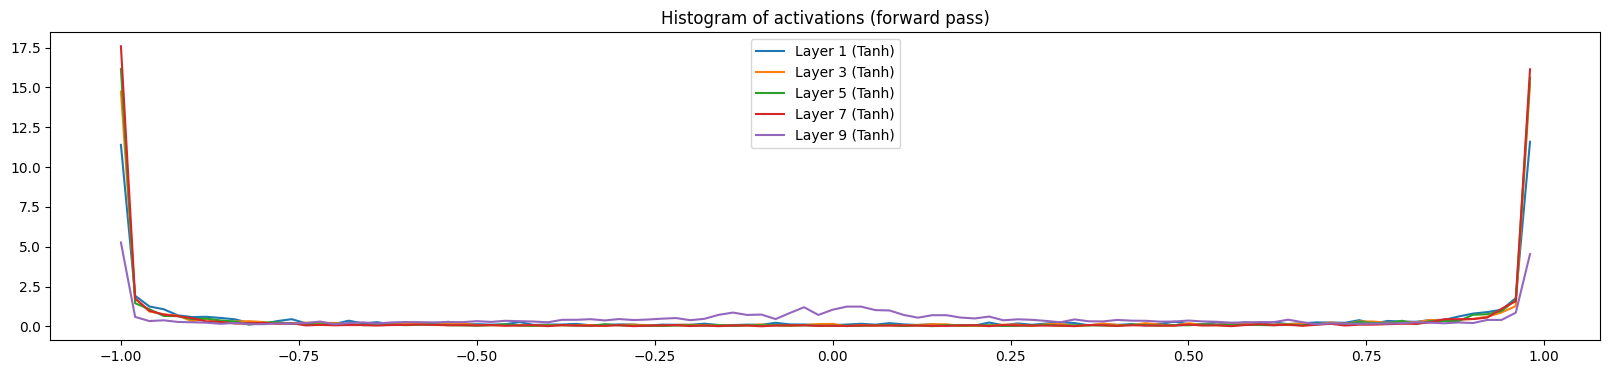

In [112]:
plt.figure(figsize=(20, 4))
legends = []

for i, layer in enumerate(layers[:-1]):
  if isinstance(layer, Tanh):
    t = layer.out    
    mean = t.mean().item()
    std = t.std().item()
    saturation = (t.abs() > 0.97).float().mean().item()*100
    print(f"Layer {i} ({layer.__class__.__name__}): mean {mean:+.2f}, std {std:.2f}, saturated {saturation:.2f}%")
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f"Layer {i} ({layer.__class__.__name__})")
plt.legend(legends)
plt.title("Histogram of activations (forward pass)");

Layer 1 (Tanh): mean -0.00, std 0.00
Layer 3 (Tanh): mean -0.00, std 0.00
Layer 5 (Tanh): mean -0.00, std 0.00
Layer 7 (Tanh): mean -0.00, std 0.00
Layer 9 (Tanh): mean -0.00, std 0.00


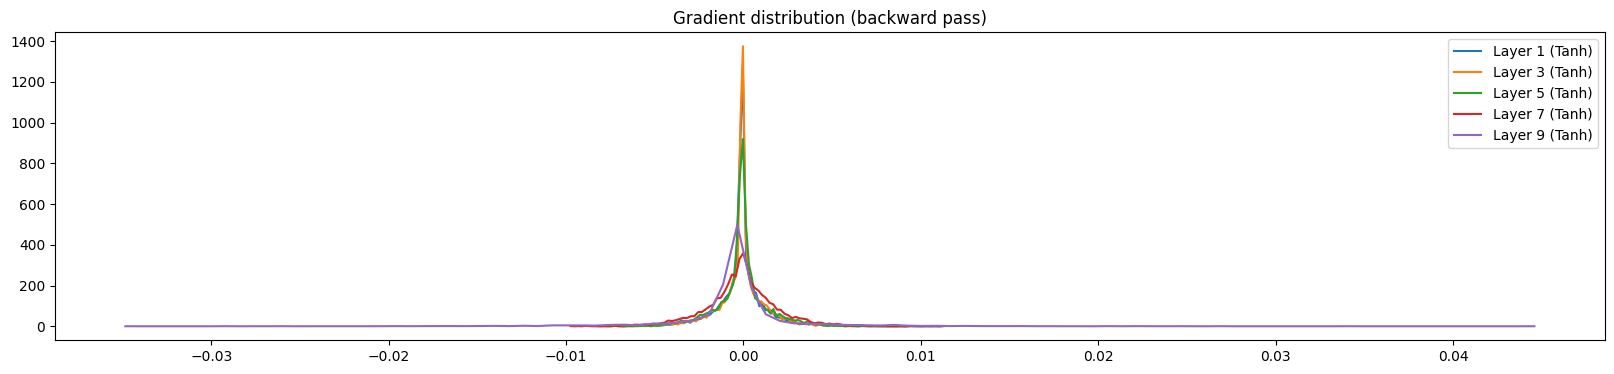

In [113]:
plt.figure(figsize=(20, 4))
legends = []

for i, layer in enumerate(layers[:-1]):
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print(f"Layer {i} ({layer.__class__.__name__}): mean {t.mean().item():+.2f}, std {t.std().item():.2f}")
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f"Layer {i} ({layer.__class__.__name__})")
plt.legend(legends)
plt.title("Gradient distribution (backward pass)");

Weight (27, 10)   | mean +0.00 | std 0.01 | grad:data ration 0.01
Weight (30, 200)  | mean -0.00 | std 0.00 | grad:data ration 0.01
Weight (200, 200) | mean -0.00 | std 0.00 | grad:data ration 0.01
Weight (200, 200) | mean +0.00 | std 0.00 | grad:data ration 0.01
Weight (200, 200) | mean +0.00 | std 0.00 | grad:data ration 0.01
Weight (200, 200) | mean -0.00 | std 0.00 | grad:data ration 0.03
Weight (200, 27)  | mean -0.00 | std 0.02 | grad:data ration 0.14


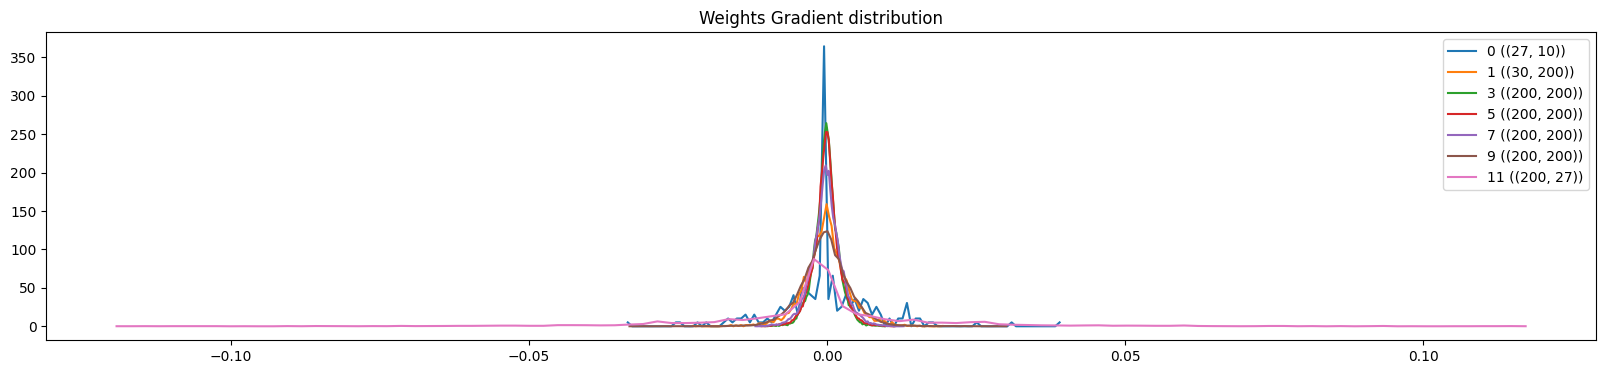

In [114]:
plt.figure(figsize=(20, 4))
legends = []

for i, p in enumerate(params):
  t = p.grad
  if p.ndim == 2:
    shape = str(tuple(p.shape))
    mean = t.mean().item()
    std = t.std().item()
    ratio = t.std() / p.std()
    print(f"Weight {shape:10s} | mean {mean:+.2f} | std {std:.2f} | grad:data ration {ratio:.2f}")
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f"{i} ({shape})")
plt.legend(legends)
plt.title("Weights Gradient distribution");

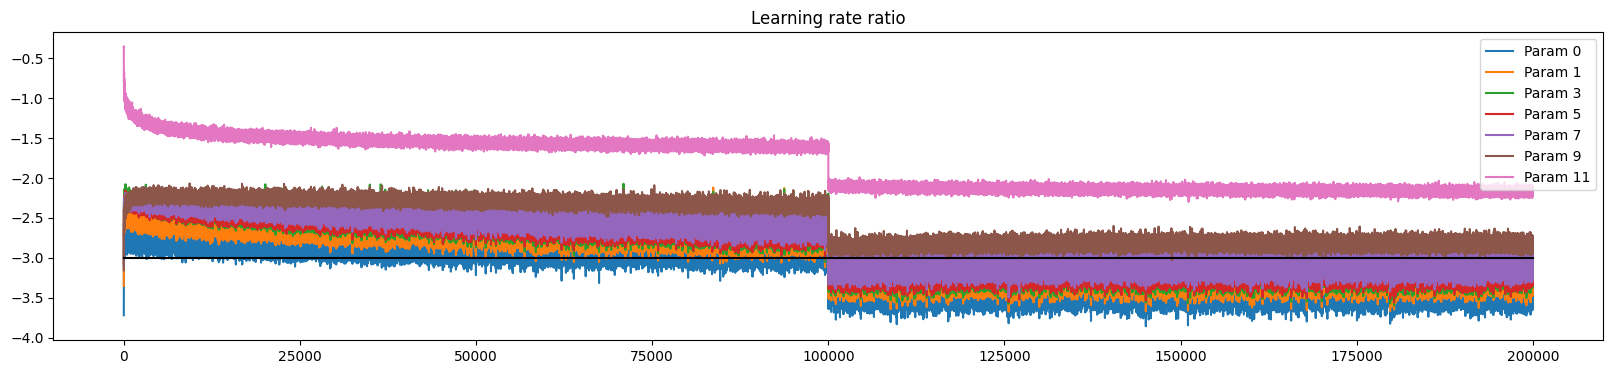

In [115]:
plt.figure(figsize=(20, 4))
legends = []

for i, p in enumerate(params):
  if p.ndim == 2:
    plt.plot([ud_ratio[j][i] for j in range(len(ud_ratio))])
    legends.append(f"Param {i}")
plt.plot([0, len(ud_ratio)], [-3, -3], "k")
plt.legend(legends)
plt.title("Learning rate ratio");

### Bringing batch normalization back

In [116]:
C = torch.randn(vocab_size, n_embd)
layers = [
  Linear(                   n_embd * context_len, n_hidden), BatchNorm(n_hidden), Tanh(),
  Linear(                               n_hidden, n_hidden), BatchNorm(n_hidden), Tanh(),
  Linear(                               n_hidden, n_hidden), BatchNorm(n_hidden), Tanh(),
  Linear(                               n_hidden, n_hidden), BatchNorm(n_hidden), Tanh(),
  Linear(                               n_hidden, n_hidden), BatchNorm(n_hidden), Tanh(),
  Linear(              n_hidden, vocab_size, kaiming=False), BatchNorm(vocab_size)
]

with torch.no_grad():
  layers[-1].gamma *= 0.1     # scale down the output layer batch norm

params = [C] + [p for layer in layers for p in layer.params()]
for p in params:
  p.requires_grad = True

print("Number of parameters: ", sum([p.nelement() for p in params]))

Number of parameters:  174751


In [117]:
lossi = []
ud_ratio = []

for step in range(steps):
  # minibatch construction
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, yb = Xtr[ix], ytr[ix]            # batch X, y

  # forward pass
  emb = C[Xb]                          # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1)  # concatenate the vectors
  for layer in layers:
    embcat = layer(embcat)
  loss = F.cross_entropy(embcat, yb)   # loss function

  # backward pass
  for layer in layers:
     layer.out.retain_grad()
  for p in params:
      p.grad = None
  loss.backward()
  lossi.append(loss.log10().item())

  # update
  lr = 0.15 if step < 100_000 else 0.05 # step learning rate decay
  for p in params:
      p.data -= lr * p.grad
  with torch.no_grad():
    ud_ratio.append([(lr * p.grad.std() / p.data.std()).log10().item() for p in params])

  # track stats
  if step == 0:
    print(f"Loss at {step:7d}/{steps:7d}: {loss.item():.4f}")

  if (step+1) % 20_000 == 0:
      print(f"Loss at {(step+1):7d}/{steps:7d}: {loss.item():.4f}")

Loss at       0/ 200000: 3.2935
Loss at   20000/ 200000: 1.9721
Loss at   40000/ 200000: 2.0900
Loss at   60000/ 200000: 2.1715
Loss at   80000/ 200000: 2.2793
Loss at  100000/ 200000: 2.3798
Loss at  120000/ 200000: 1.9016
Loss at  140000/ 200000: 2.1031
Loss at  160000/ 200000: 1.9787
Loss at  180000/ 200000: 1.7101
Loss at  200000/ 200000: 1.8104


Layer 2 (Tanh): mean -0.00, std 0.70, saturated 17.08%
Layer 5 (Tanh): mean +0.01, std 0.74, saturated 20.31%
Layer 8 (Tanh): mean +0.01, std 0.77, saturated 20.19%
Layer 11 (Tanh): mean +0.01, std 0.79, saturated 20.47%
Layer 14 (Tanh): mean +0.00, std 0.80, saturated 22.23%


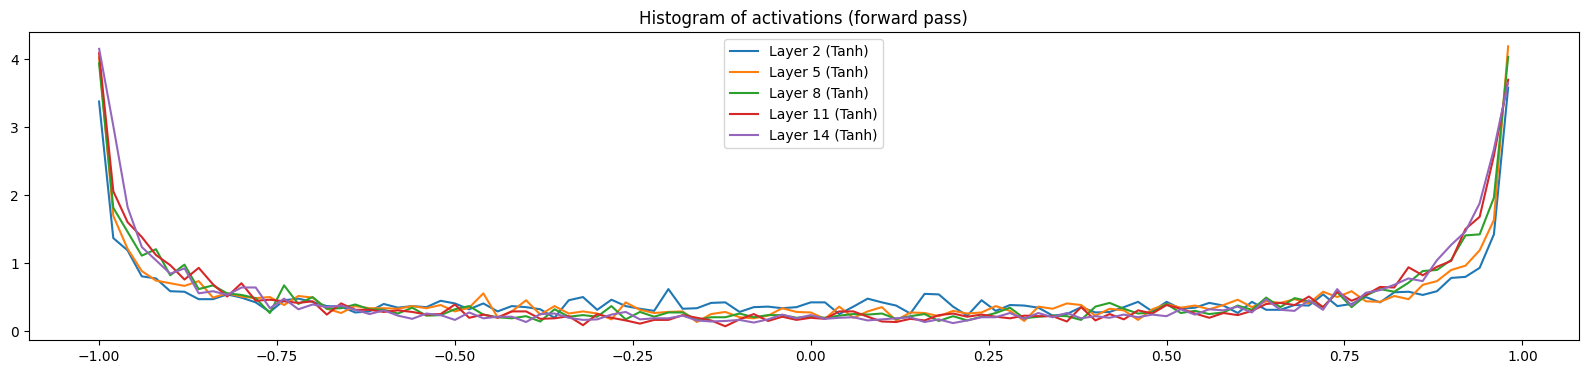

In [118]:
plt.figure(figsize=(20, 4))
legends = []

for i, layer in enumerate(layers[:-1]):
  if isinstance(layer, Tanh):
    t = layer.out    
    mean = t.mean().item()
    std = t.std().item()
    saturation = (t.abs() > 0.97).float().mean().item()*100
    print(f"Layer {i} ({layer.__class__.__name__}): mean {mean:+.2f}, std {std:.2f}, saturated {saturation:.2f}%")
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f"Layer {i} ({layer.__class__.__name__})")
plt.legend(legends)
plt.title("Histogram of activations (forward pass)");

Layer 2 (Tanh): mean -0.00, std 0.00
Layer 5 (Tanh): mean -0.00, std 0.00
Layer 8 (Tanh): mean -0.00, std 0.00
Layer 11 (Tanh): mean +0.00, std 0.00
Layer 14 (Tanh): mean +0.00, std 0.00


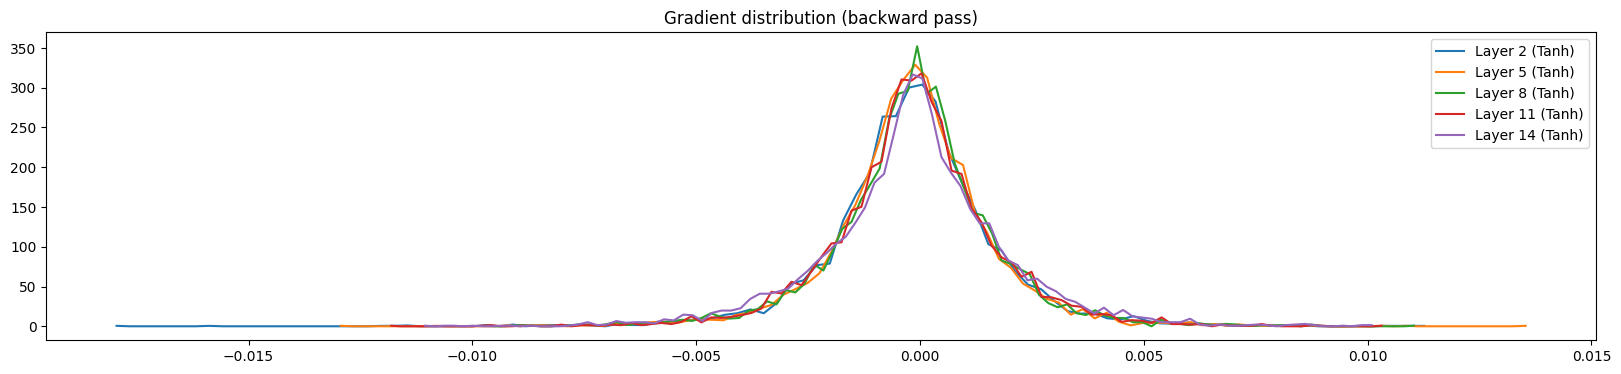

In [119]:
plt.figure(figsize=(20, 4))
legends = []

for i, layer in enumerate(layers[:-1]):
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print(f"Layer {i} ({layer.__class__.__name__}): mean {t.mean().item():+.2f}, std {t.std().item():.2f}")
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f"Layer {i} ({layer.__class__.__name__})")
plt.legend(legends)
plt.title("Gradient distribution (backward pass)");

Weight (27, 10)   | mean -0.00 | std 0.01 | grad:data ration 0.01
Weight (30, 200)  | mean +0.00 | std 0.00 | grad:data ration 0.01
Weight (200, 200) | mean +0.00 | std 0.00 | grad:data ration 0.01
Weight (200, 200) | mean +0.00 | std 0.00 | grad:data ration 0.01
Weight (200, 200) | mean -0.00 | std 0.00 | grad:data ration 0.01
Weight (200, 200) | mean -0.00 | std 0.00 | grad:data ration 0.01
Weight (200, 27)  | mean -0.00 | std 0.01 | grad:data ration 0.02


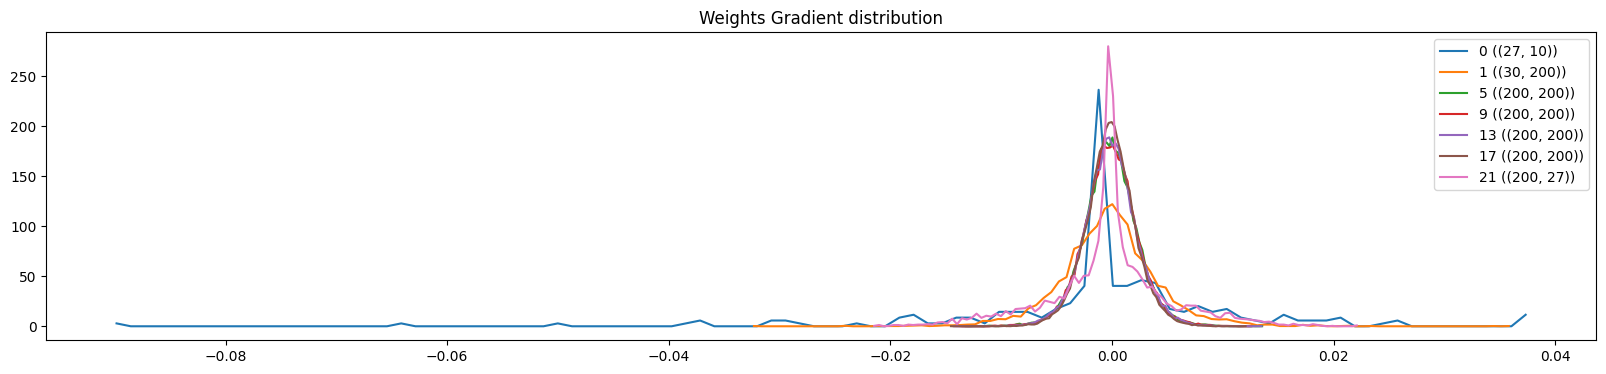

In [123]:
plt.figure(figsize=(20, 4))
legends = []

for i, p in enumerate(params):
  t = p.grad
  if p.ndim == 2 and p.shape[0] != 1:
    shape = str(tuple(p.shape))
    mean = t.mean().item()
    std = t.std().item()
    ratio = t.std() / p.std()
    print(f"Weight {shape:10s} | mean {mean:+.2f} | std {std:.2f} | grad:data ration {ratio:.2f}")
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f"{i} ({shape})")
plt.legend(legends)
plt.title("Weights Gradient distribution");

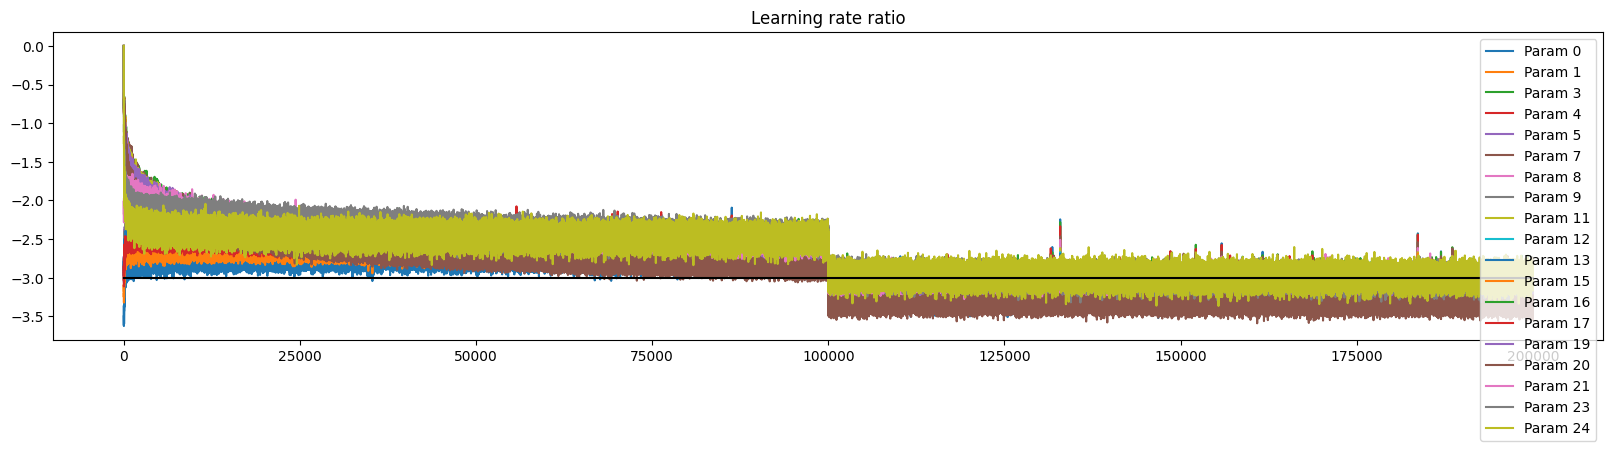

In [124]:
plt.figure(figsize=(20, 4))
legends = []

for i, p in enumerate(params):
  if p.ndim == 2:
    plt.plot([ud_ratio[j][i] for j in range(len(ud_ratio))])
    legends.append(f"Param {i}")
plt.plot([0, len(ud_ratio)], [-3, -3], "k")
plt.legend(legends)
plt.title("Learning rate ratio");

# Sources

1. [Ground truth - Building makemore Part 3: Activations & Gradients, BatchNorm, By Andrej Karpathy](https://www.youtube.com/watch?v=P6sfmUTpUmc&list=PPSV)
2. Kaiming He, et al. Delving deep into rectifiers: Surpassing human-level performance on ImageNet classification, 2015. URL: https://arxiv.org/pdf/1502.01852.pdf
3. Ioffe, Sergey, Szegedy, Christian. Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift, 2015. URL: https://arxiv.org/pdf/1502.03167.pdf